In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
import os
import pandas as pd
base_path = r'Dataset' 

train_original_dir = os.path.join(base_path, "TRAINING_CG-1050", "TRAINING", "ORIGINAL")
train_tampered_dir = os.path.join(base_path, "TRAINING_CG-1050", "TRAINING", "TAMPERED")
val_original_dir = os.path.join(base_path, "VALIDATION_CG-1050", "VALIDATION", "ORIGINAL")
val_tampered_dir = os.path.join(base_path, "VALIDATION_CG-1050", "VALIDATION", "TAMPERED")


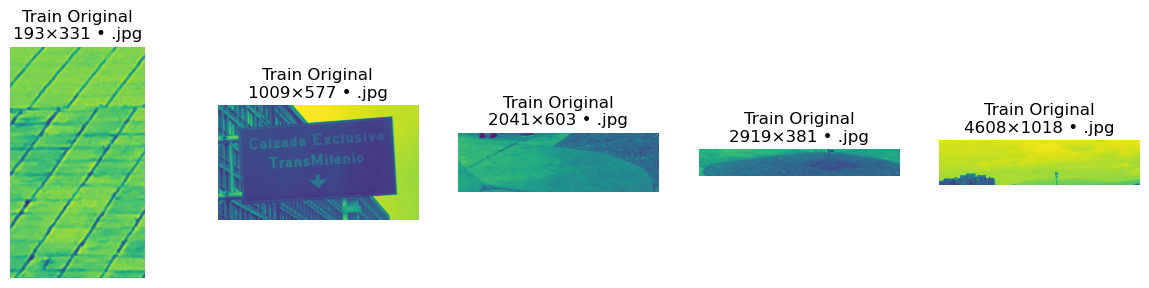

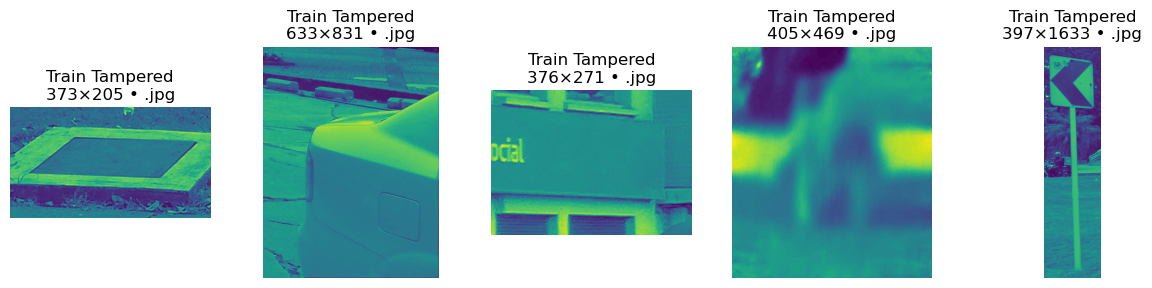

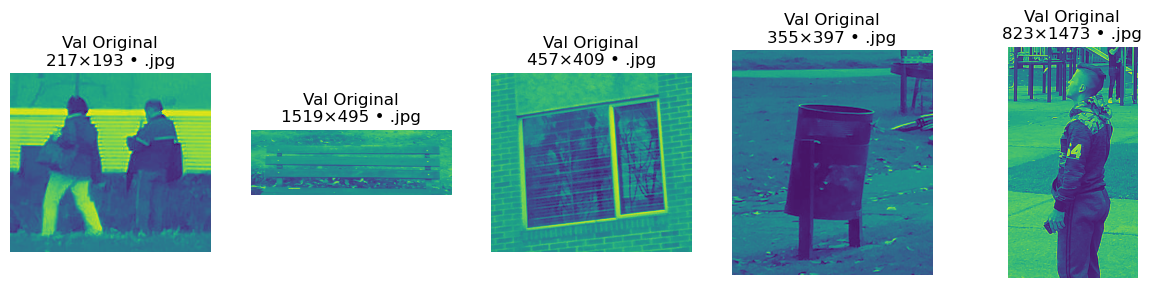

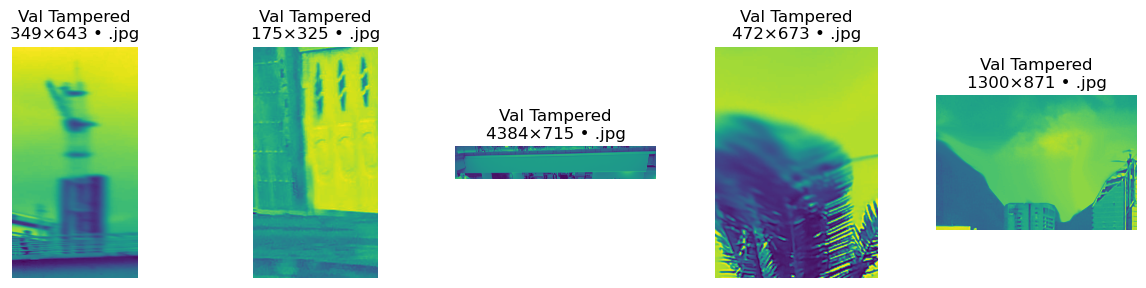

Class balance:
  Train Original : 730 images
  Train Tampered : 730 images
  Val Original   : 314 images
  Val Tampered   : 314 images


In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

base_path = r'Dataset'

categories = {
    'Train Original': os.path.join(base_path, 'TRAINING_CG-1050', 'TRAINING', 'ORIGINAL'),
    'Train Tampered': os.path.join(base_path, 'TRAINING_CG-1050', 'TRAINING', 'TAMPERED'),
    'Val Original': os.path.join(base_path, 'VALIDATION_CG-1050', 'VALIDATION', 'ORIGINAL'),
    'Val Tampered': os.path.join(base_path, 'VALIDATION_CG-1050', 'VALIDATION', 'TAMPERED'),
}

def display_samples(path, title, n=5):
    files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    samples = random.sample(files, min(n, len(files)))
    plt.figure(figsize=(15, 3))
    for i, fname in enumerate(samples):
        img = Image.open(os.path.join(path, fname))
        w, h = img.size
        ext = fname.split('.')[-1]
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f'{title}\n{w}×{h} • .{ext}')
        plt.axis('off')
    plt.show()

for title, path in categories.items():
    display_samples(path, title)

print("Class balance:")
for title, path in categories.items():
    count = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    print(f"  {title:15s}: {count} images")


In [ ]:
import os
import pandas as pd

base_dir = "Dataset"

train_original_dir = os.path.join(base_dir, "TRAINING_CG-1050", "TRAINING", "ORIGINAL")
train_tampered_dir = os.path.join(base_dir, "TRAINING_CG-1050", "TRAINING", "TAMPERED")
val_original_dir = os.path.join(base_dir, "VALIDATION_CG-1050", "VALIDATION", "ORIGINAL")
val_tampered_dir = os.path.join(base_dir, "VALIDATION_CG-1050", "VALIDATION", "TAMPERED")

def get_df_from_folder(folder_path, label, dataset_type):
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    full_paths = [os.path.join(folder_path, f) for f in files]
    return pd.DataFrame({
        'filepath': full_paths,
        'label': label,
        'set': dataset_type
    })

train_df = pd.concat([
    get_df_from_folder(train_original_dir, 0, "train"),
    get_df_from_folder(train_tampered_dir, 1, "train")
], ignore_index=True)

val_df = pd.concat([
    get_df_from_folder(val_original_dir, 0, "val"),
    get_df_from_folder(val_tampered_dir, 1, "val")
], ignore_index=True)

full_df = pd.concat([train_df, val_df], ignore_index=True)

print(full_df.head())
print(full_df['set'].value_counts())


                                            filepath  label    set
0  Dataset\TRAINING_CG-1050\TRAINING\ORIGINAL\Im1...      0  train
1  Dataset\TRAINING_CG-1050\TRAINING\ORIGINAL\Im1...      0  train
2  Dataset\TRAINING_CG-1050\TRAINING\ORIGINAL\Im1...      0  train
3  Dataset\TRAINING_CG-1050\TRAINING\ORIGINAL\Im1...      0  train
4  Dataset\TRAINING_CG-1050\TRAINING\ORIGINAL\Im1...      0  train
set
train    1460
val       628
Name: count, dtype: int64


In [ ]:
from PIL import Image, ImageChops, ImageEnhance
import numpy as np
from tqdm import tqdm

def generate_ela_array(path, quality=95):
    original = Image.open(path).convert('RGB')
    original.save('temp_ela.jpg', 'JPEG', quality=quality)
    compressed = Image.open('temp_ela.jpg')
    ela_image = ImageChops.difference(original, compressed)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    ela_image = ela_image.convert('L')
    ela_image = ela_image.resize((128, 128))
    return np.array(ela_image).flatten()

ela_features = []
labels = []

for _, row in tqdm(full_df.iterrows(), total=len(full_df), desc="Extracting ELA"):
    path = row['filepath']
    label = row['label']
    
    feature = generate_ela_array(path)
    ela_features.append(feature)
    labels.append(label)

X = np.array(ela_features)
y = np.array(labels)


Extracting ELA: 100%|██████████| 2088/2088 [03:17<00:00, 10.60it/s]


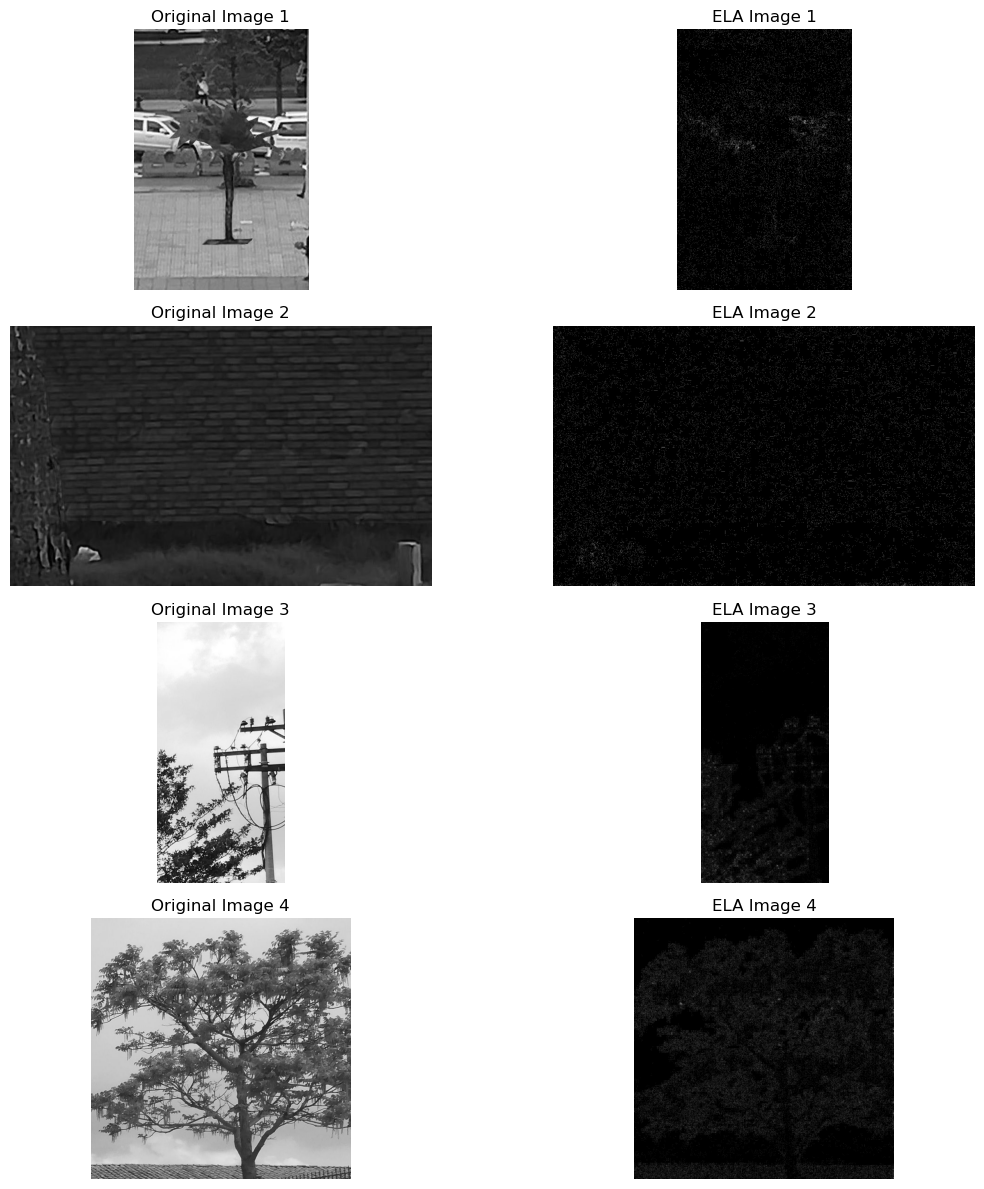

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageEnhance
import random

def show_multiple_ela_images(df, num_images=4, quality=95):
    sample_paths = random.sample(list(df['filepath']), num_images)

    plt.figure(figsize=(12, 3 * num_images))

    for i, path in enumerate(sample_paths):
        original = Image.open(path).convert('RGB')
        original.save('temp_ela.jpg', 'JPEG', quality=quality)
        compressed = Image.open('temp_ela.jpg')
        ela_image = ImageChops.difference(original, compressed)

        extrema = ela_image.getextrema()
        max_diff = max([ex[1] for ex in extrema]) if extrema else 0
        if max_diff == 0:
            max_diff = 1 
        scale = 255.0 / max_diff  
        
        ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
        
        ela_image = ela_image.point(lambda p: p if p > 10 else 0)  

        # Original Image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(original)
        plt.title(f"Original Image {i+1}")
        plt.axis('off')

        # ELA Image
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(ela_image, cmap='gray')
        plt.title(f"ELA Image {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_multiple_ela_images(full_df, num_images=4)


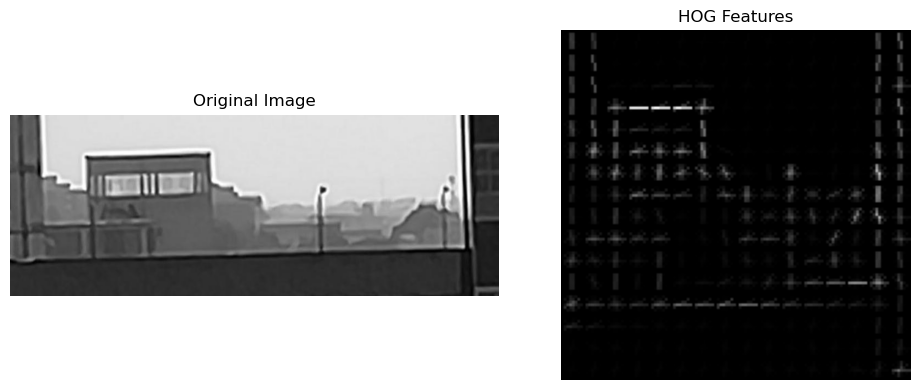

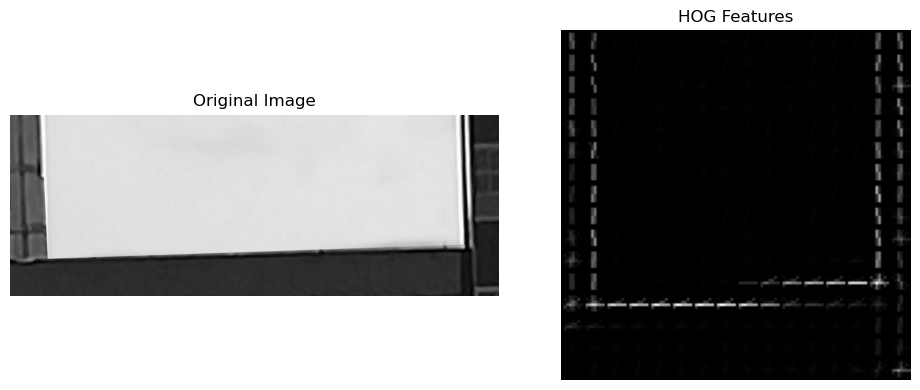

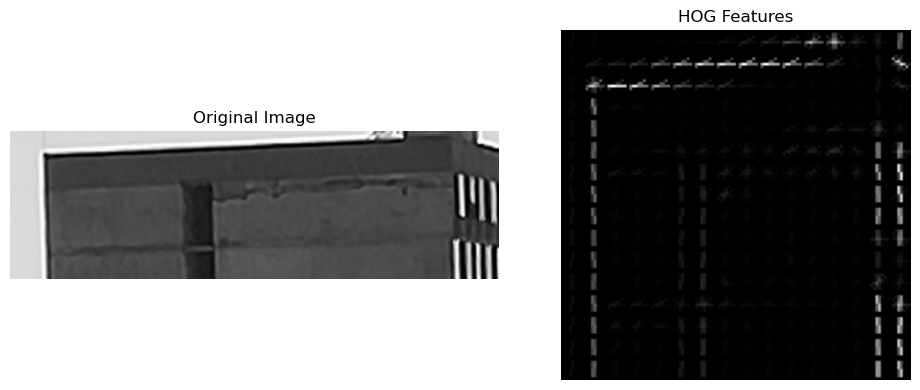

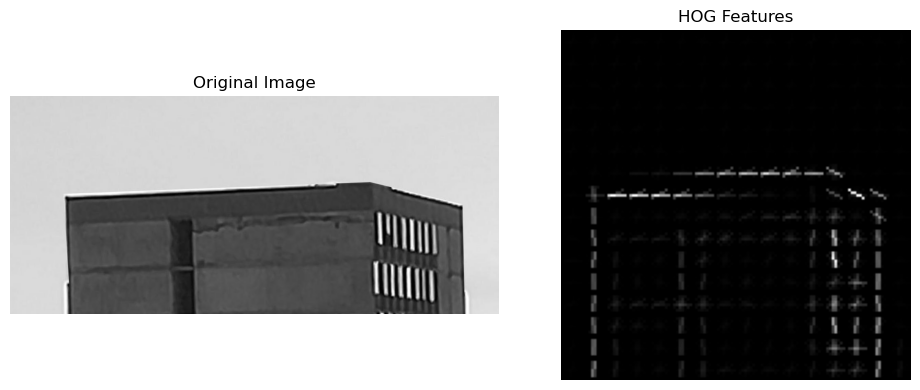

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog

def visualize_hog(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (128, 128))  
    features, hog_image = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True
    )
    return image, hog_image

sample_paths = [
    os.path.join(train_original_dir, os.listdir(train_original_dir)[0]),
    os.path.join(train_tampered_dir, os.listdir(train_tampered_dir)[0]),
    os.path.join(train_original_dir, os.listdir(train_original_dir)[1]),
    os.path.join(train_tampered_dir, os.listdir(train_tampered_dir)[1])
]

for path in sample_paths:
    original, hog_img = visualize_hog(path)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(hog_img, cmap='gray')
    plt.title('HOG Features')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
import cv2
import numpy as np
from skimage.feature import hog
from tqdm import tqdm

# Resize target size
IMG_SIZE = (128, 128)

# HOG params
hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
    'transform_sqrt': True,
    'feature_vector': True
}

def extract_hog_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return np.zeros(8100)  
    img = cv2.resize(img, IMG_SIZE)
    features = hog(img, **hog_params)
    return features

hog_features = []
for path in tqdm(full_df['filepath'], desc="Extracting HOG features"):
    features = extract_hog_features(path)
    hog_features.append(features)

X = np.vstack(hog_features)
y = full_df['label'].values

print(f"HOG feature shape: {X.shape}")


Extracting HOG features: 100%|██████████| 2088/2088 [00:34<00:00, 61.38it/s] 


HOG feature shape: (2088, 8100)


In [ ]:
import numpy as np
from skimage.feature import hog
from PIL import Image, ImageChops, ImageEnhance
from tqdm import tqdm
import cv2

def generate_ela_array(path, quality=95):
    original = Image.open(path).convert('RGB')
    original.save('temp_ela.jpg', 'JPEG', quality=quality)
    compressed = Image.open('temp_ela.jpg')
    ela_image = ImageChops.difference(original, compressed)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff if max_diff != 0 else 1

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    ela_image = ela_image.convert('L').resize((128, 128))
    return np.array(ela_image).flatten()

def extract_hog_feature(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))
    features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
    return features

hog_features = []
ela_features = []

print("Extracting features (HOG + ELA)...")
for path in tqdm(full_df['filepath'], desc="Extracting Combined Features"):
    hog_feat = extract_hog_feature(path)
    ela_feat = generate_ela_array(path)
    
    combined_feat = np.concatenate([hog_feat, ela_feat])
    
    hog_features.append(combined_feat)

X_combined = np.vstack(hog_features)
y = full_df['label'].values

print("Combined feature shape:", X_combined.shape)


🔁 Extracting features (HOG + ELA)...


Extracting Combined Features: 100%|██████████| 2088/2088 [04:22<00:00,  7.96it/s]


✅ Combined feature shape: (2088, 24484)


In [ ]:
import cv2
import numpy as np
from skimage.feature import hog
from PIL import Image
from tqdm import tqdm
import os

def extract_hog_features(image):
    try:
        image_resized = cv2.resize(image, (128, 128))
        fd, _ = hog(image_resized, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        return fd
    except Exception as e:
        print(f"Error extracting HOG features: {e}")
        return None

def generate_ela_array(image_path, quality=95):
    try:
        original = Image.open(image_path).convert('RGB')
        
        original = original.resize((128, 128))
        
        original.save('temp_ela.jpg', 'JPEG', quality=quality)
        compressed = Image.open('temp_ela.jpg')
        
        ela = np.array(original) - np.array(compressed)
        return ela.flatten()  
    except Exception as e:
        print(f"Error generating ELA for {image_path}: {e}")
        return None

original_folder = r'Dataset\TRAINING_CG-1050\TRAINING\ORIGINAL'
tampered_folder = r'Dataset\TRAINING_CG-1050\TRAINING\TAMPERED'

def get_image_paths(folder):
    image_paths = []
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png')):  
                image_paths.append(os.path.join(subdir, file))
    return image_paths

original_images = get_image_paths(original_folder)
tampered_images = get_image_paths(tampered_folder)

image_paths = original_images + tampered_images

X_hog = []
for path in tqdm(image_paths, desc="Extracting HOG features"):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        hog_features = extract_hog_features(image)
        if hog_features is not None:
            X_hog.append(hog_features)
        else:
            print(f"Error extracting HOG features for {path}")
    else:
        print(f"Error loading image: {path}")

X_hog = np.array(X_hog)
print(f"Shape of HOG features: {X_hog.shape}")

X_ela = []
for path in tqdm(image_paths, desc="Extracting ELA features"):
    ela_features = generate_ela_array(path, quality=95)
    if ela_features is not None:
        print(f"Shape of ELA features for {path}: {ela_features.shape}")
        X_ela.append(ela_features)
    else:
        print(f"Error extracting ELA features for {path}")

X_ela = np.array([x for x in X_ela if x is not None])

if X_ela.shape[0] > 0:
    print(f"Shape of ELA features: {X_ela.shape}")
else:
    print("No valid ELA features were extracted")

if X_hog.shape[0] == X_ela.shape[0]:

    combined_features = np.concatenate((X_hog, X_ela), axis=1)
    print(f" Combined feature shape: {combined_features.shape}")
else:
    print(f"Error: Mismatch in the number of samples. HOG shape: {X_hog.shape}, ELA shape: {X_ela.shape}")


In [ ]:
# Debug HOG feature extraction
X_hog = []
for path in tqdm(image_paths, desc="Extracting HOG features"):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        hog_features = extract_hog_features(image)
        if hog_features is not None:
            X_hog.append(hog_features)
        else:
            print(f"Error extracting HOG features for {path}")
    else:
        print(f"Error loading image: {path}")

X_hog = np.array(X_hog)
print(f"Shape of HOG features: {X_hog.shape}")

X_ela = []
for path in tqdm(image_paths, desc="Extracting ELA features"):
    ela_features = generate_ela_array(path, quality=95)
    if ela_features is not None:
        print(f"Shape of ELA features for {path}: {ela_features.shape}")
        X_ela.append(ela_features)
    else:
        print(f"Error extracting ELA features for {path}")

X_ela = np.array([x for x in X_ela if x is not None])
print(f"Shape of ELA features: {X_ela.shape}")

if X_hog.shape[0] == X_ela.shape[0]:
    combined_features = np.concatenate((X_hog, X_ela), axis=1)
    print(f"Combined feature shape: {combined_features.shape}")
else:
    print(f"Error: Mismatch in the number of samples. HOG shape: {X_hog.shape}, ELA shape: {X_ela.shape}")


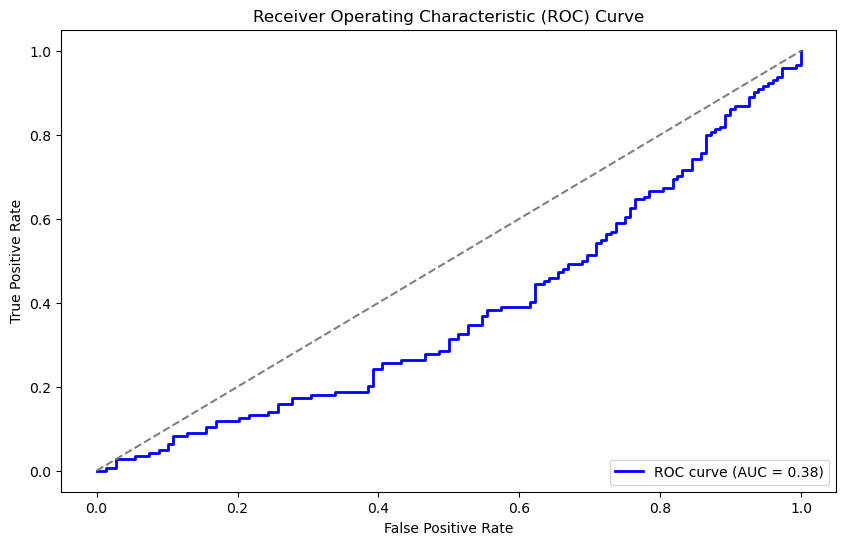

Threshold = 0.5
Accuracy: 0.4041
Precision: 0.3929
Recall: 0.3819
F1-score: 0.3873


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

threshold = 0.5
y_pred = (y_pred_prob >= threshold).astype(int)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Threshold = {threshold}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

labels = np.array([0] * len(original_images) + [1] * len(tampered_images))

X_train, X_val, y_train, y_val = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred_prob = clf.predict_proba(X_val)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

j_statistic = tpr - fpr
best_threshold = thresholds[np.argmax(j_statistic)]

print(f"Optimal Threshold (based on Youden's J statistic): {best_threshold:.4f}")

y_pred = (y_pred_prob >= best_threshold).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")


In [73]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

def extract_hog_features(image):
    image_resized = cv2.resize(image, (128, 128))
    fd, _ = hog(image_resized, orientations=9, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), visualize=True)
    return fd

def generate_ela_array(path, quality=95):
    img = Image.open(path).convert('RGB').resize((128, 128))
    img.save('temp.jpg', 'JPEG', quality=quality)
    comp = Image.open('temp.jpg')
    ela = np.array(img) - np.array(comp)
    return ela.flatten()

def get_image_paths(folder):
    paths = []
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(('jpg','jpeg','png')):
                paths.append(os.path.join(root, f))
    return sorted(paths)

orig = get_image_paths(r'Dataset\TRAINING_CG-1050\TRAINING\ORIGINAL')
tamp = get_image_paths(r'Dataset\TRAINING_CG-1050\TRAINING\TAMPERED')
paths = orig + tamp
labels = np.array([0]*len(orig) + [1]*len(tamp))

X_hog = []
for p in tqdm(paths, desc="HOG"):
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    X_hog.append(extract_hog_features(img))
X_hog = np.vstack(X_hog)

X_ela = []
for p in tqdm(paths, desc="ELA"):
    X_ela.append(generate_ela_array(p))
X_ela = np.vstack(X_ela)

X = np.hstack((X_hog, X_ela))

X_train, X_test, y_train, y_test = train_test_split(X, labels,
                                                    test_size=0.2,
                                                    stratify=labels,
                                                    random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

pca = PCA(n_components=50, random_state=42)
X_train = pca.fit_transform(X_train)
X_test  = pca.transform(X_test)

rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
gs = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

best = gs.best_estimator_
y_pred = best.predict(X_test)

print("Best Params:", gs.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Report:\n", classification_report(y_test, y_pred))


HOG:   0%|          | 0/1460 [00:00<?, ?it/s]

ELA: 100%|██████████| 1460/1460 [00:54<00:00, 26.86it/s]


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.5787671232876712
Report:
               precision    recall  f1-score   support

           0       0.56      0.71      0.63       146
           1       0.61      0.45      0.52       146

    accuracy                           0.58       292
   macro avg       0.58      0.58      0.57       292
weighted avg       0.58      0.58      0.57       292



In [ ]:
labels = np.array([0] * 730 + [1] * 730)
print(f"Labels shape: {labels.shape}")


Labels shape: (1460,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca, labels, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (1168, 150)
Testing set shape: (292, 150)


In [76]:
print("Array shape:", preprocessed_images.shape)
#(2088, 224, 224, 3)


Array shape: (2088, 224, 224, 3)


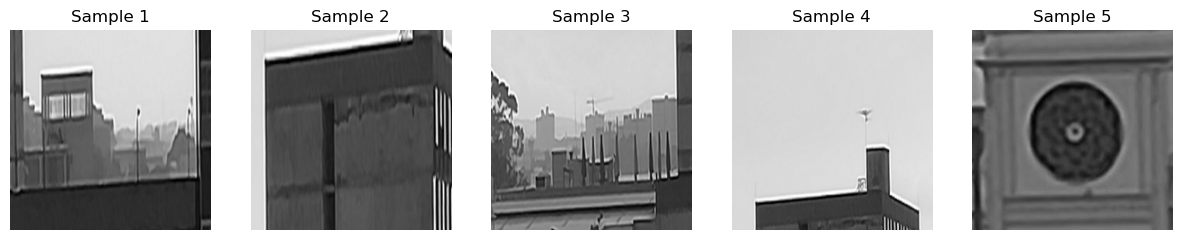

In [11]:
import matplotlib.pyplot as plt

def show_preprocessed_samples(arr, num=5):
    plt.figure(figsize=(15,3))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(arr[i])
        plt.title(f"Sample {i+1}")
        plt.axis('off')
    plt.show()

show_preprocessed_samples(preprocessed_images, num=5)


In [ ]:
from PIL import Image, ImageChops, ImageEnhance
import numpy as np

def generate_ela_array(path, quality=95):
    try:
        original = Image.open(path).convert('RGB')
        original.save('temp_ela.jpg', 'JPEG', quality=quality)
        compressed = Image.open('temp_ela.jpg')
        ela_image = ImageChops.difference(original, compressed)

        extrema = ela_image.getextrema()
        max_diff = max([ex[1] for ex in extrema])
        if max_diff == 0:
            max_diff = 1
        scale = 255.0 / max_diff

        ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
        ela_image = ela_image.convert('L') 
        ela_image = ela_image.resize((128, 128))  
        return np.array(ela_image).flatten()
    except Exception as e:
        print(f"ELA error {path}: {e}")
        return np.zeros((128 * 128,))


In [ ]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def preprocess_ela_features(df):
    with ThreadPoolExecutor() as executor:
        ela_features = list(tqdm(
            executor.map(lambda row: generate_ela_array(row.filepath), df.itertuples(index=False)),
            total=len(df)
        ))
    return np.array(ela_features)

# Run it
X = preprocess_ela_features(full_df)
y = full_df['label'].values


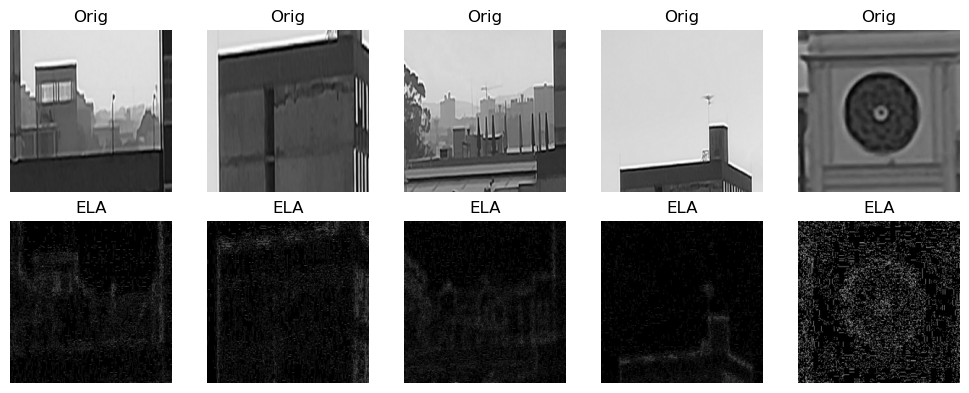

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(preprocessed_images[i])
    plt.title("Orig")
    plt.axis('off')
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(preprocessed_ela[i])
    plt.title("ELA")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def prediction(images):
    n_orig = len(val_images_original)
    threshold = int(alpha * n_orig)
    return [0 if i < threshold else 1 for i in range(len(images))]
preds = prediction(val_images)

acc   = accuracy_score(true_labels, preds)
prec  = precision_score(true_labels, preds, zero_division=0)
rec   = recall_score(true_labels, preds, zero_division=0)
f1    = f1_score(true_labels, preds, zero_division=0)
cm    = confusion_matrix(true_labels, preds)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print("Confusion Matrix:\n", cm)


Accuracy:  0.9490
Precision: 0.9075
Recall:    1.0000
F1-score:  0.9515
Confusion Matrix:
 [[282  32]
 [  0 314]]


In [84]:
pip install joblib


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import joblib
joblib.dump(model, 'model.pkl')  


['model.pkl']

In [ ]:
import joblib
model = joblib.load('model.pkl')


In [ ]:
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
joblib.dump(model, 'model.pkl')  
model = joblib.load('model.pkl')  
def prediction(images, alpha=0.90):
    n_orig = len(val_images_original)
    threshold = int(alpha * n_orig)
    return [0 if i < threshold else 1 for i in range(len(images))]

preds = prediction(val_images)

acc = accuracy_score(true_labels, preds)
prec = precision_score(true_labels, preds, zero_division=0)
rec = recall_score(true_labels, preds, zero_division=0)
f1 = f1_score(true_labels, preds, zero_division=0)
cm = confusion_matrix(true_labels, preds)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print("Confusion Matrix:\n", cm)


Accuracy:  0.9490
Precision: 0.9075
Recall:    1.0000
F1-score:  0.9515
Confusion Matrix:
 [[282  32]
 [  0 314]]
